In [20]:
%%capture
%pip install langchain-openai==0.3.27
%pip install langgraph==0.6.6
%pip install pygraphviz==1.14

In [21]:
from langgraph.graph import StateGraph, END,START
from typing import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph

In [22]:
def print_workflow_info(workflow, app=None):
    """Prints comprehensive information about a LangGraph workflow."""
    print("WORKFLOW INFORMATION")
    print("====================")
    print(f"Nodes: {workflow.nodes}")
    print(f"Edges: {workflow.edges}")

    
    # Use getter method for finish points if available
    try:
        finish_points = workflow.finish_points
        print(f"Finish points: {finish_points}")
    except:
        try:
            # Alternative approaches
            print(f"Finish point: {workflow._finish_point}")
        except:
            print("Finish points attribute not directly accessible")
    
    if app:
        print("\nWorkflow Visualization:")
        from IPython.display import display
        display(app.get_graph().draw_png())

In [23]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [24]:
class ChainState(TypedDict):
    job_description: str
    resume_summary: str
    cover_letter: str

In [25]:
def generate_resume_summary(state: ChainState) -> ChainState:
    prompt = f"""
You're a resume assistant. Read the following job description and summarize the key qualifications and experience the ideal candidate should have, phrased as if from the perspective of a strong applicant's resume summary.

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "resume_summary": response.content}

In [26]:
def generate_cover_letter(state: ChainState) -> ChainState:
    prompt = f"""
You're a cover letter writing assistant. Using the resume summary below, write a professional and personalized cover letter for the following job.

Resume Summary:
{state['resume_summary']}

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "cover_letter": response.content}

In [27]:
workflow = StateGraph(ChainState)
workflow

In [28]:
workflow.add_node("generate_resume_summary", generate_resume_summary)
workflow.add_node("generate_cover_letter", generate_cover_letter)

In [29]:
workflow.set_entry_point("generate_resume_summary")

In [30]:
workflow.add_edge("generate_resume_summary", "generate_cover_letter")

In [31]:
workflow.set_finish_point("generate_cover_letter")

In [32]:
print_workflow_info(workflow)

WORKFLOW INFORMATION
Nodes: {'generate_resume_summary': StateNodeSpec(runnable=generate_resume_summary(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'generate_cover_letter': StateNodeSpec(runnable=generate_cover_letter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}
Edges: {('__start__', 'generate_resume_summary'), ('generate_resume_summary', 'generate_cover_letter'), ('generate_cover_letter', '__end__')}
Finish points attribute not directly accessible


In [33]:
app = workflow.compile()

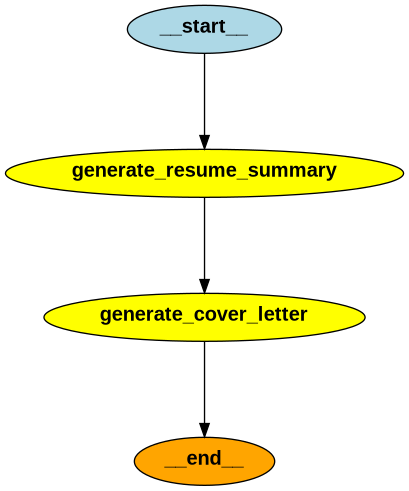

In [34]:
from IPython.display import Image, display

# Generate a visualization of the workflow graph
display(Image(app.get_graph().draw_png()))

In [35]:
input_state = {
        "job_description": "We are looking for a data scientist with experience in machine learning, NLP, and Python. Prior work with large datasets and experience deploying models into production is required."
}

result = app.invoke(input_state)

In [36]:
result['resume_summary']

'Results-driven data scientist with extensive experience in machine learning and natural language processing (NLP). Proficient in Python and skilled in working with large datasets, I have successfully deployed machine learning models into production environments, demonstrating a strong ability to translate complex data into actionable insights. Committed to leveraging advanced analytical techniques to drive business solutions and enhance decision-making processes.'

In [37]:
result['cover_letter']

"[Your Name]  \n[Your Address]  \n[City, State, Zip]  \n[Your Email]  \n[Your Phone]  \n[Date]  \n\n[Hiring Manager's Name]  \n[Company Name]  \n[Company Address]  \n[City, State, Zip]  \n\nDear [Hiring Manager's Name],\n\nI am excited to apply for the Data Scientist position at [Company Name], as advertised. With my extensive experience in machine learning and natural language processing (NLP), along with my proficiency in Python, I am confident in my ability to contribute effectively to your team and help drive impactful data-driven solutions.\n\nIn my previous roles, I have successfully worked with large datasets and deployed machine learning models into production environments, providing me with a robust understanding of the complexities involved in processing and analyzing significant volumes of data. This hands-on experience has not only honed my technical skills but has also equipped me with the ability to translate complex data findings into actionable insights that can influen